<h2><span style="background: linear-gradient(to right, red, orange, yellow, green, blue, indigo, violet); -webkit-background-clip: text; color: transparent;">The5Outliers</span></h2>
<h3> Data preprocessing and embedding </h3>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from urllib.parse import unquote

sys.path.append('./src/models/')

import similarity_matrix as sm

In [14]:
data_path = './data/paths-and-graph'
df_article_names = pd.read_csv(os.path.join(data_path, 'articles.tsv'), skiprows=11, header=None).squeeze()
df_article_names.rename('article_names')
df_article_names = df_article_names.apply(unquote)
df_article_names = df_article_names.replace('_', ' ', regex=True)
df_article_names

0           Áedán mac Gabráin
1                       Åland
2               Édouard Manet
3                        Éire
4       Óengus I of the Picts
                ...          
4599                  Zionism
4600                Zirconium
4601                Zoroaster
4602             Zuid-Gelders
4603                     Zulu
Name: 0, Length: 4604, dtype: object

## Analysis 

In [4]:
embeddings, similarity_matrix = sm.load_embedding_similarity_matrix()
print(f'There are {embeddings.shape[0]} embeddings of shape {embeddings.shape[1]} and dtype {embeddings.dtype}')
print(f'The similarity matrix is of shape {similarity_matrix.shape} and dtype {similarity_matrix.dtype}')

There are 4604 embeddings of shape 1024 and dtype float32
The similarity matrix is of shape (4604, 4604) and dtype float32


Text(0.5, 1.0, 'Cosine similarity of article names')

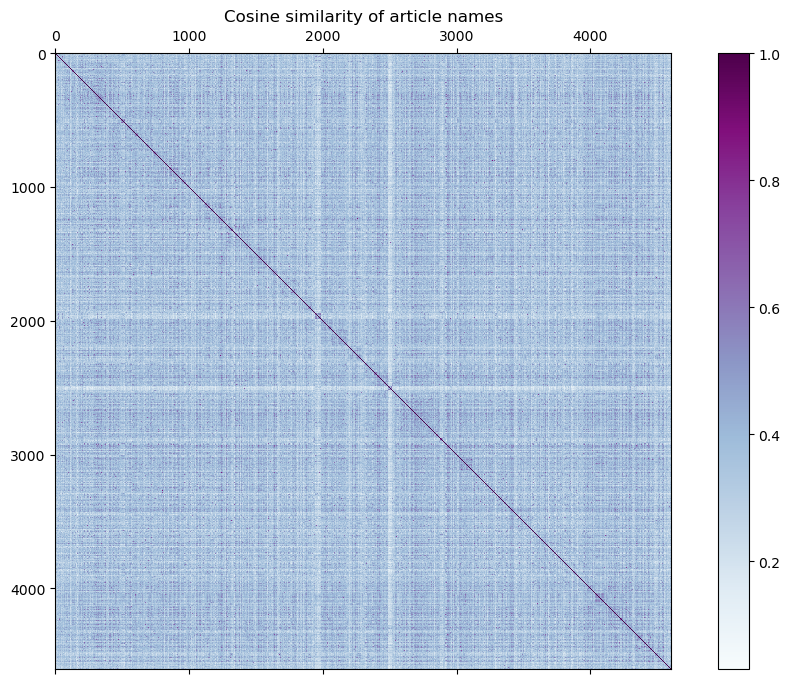

In [115]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(similarity_matrix, cmap='BuPu')
cbar = fig.colorbar(cax)
plt.title('Cosine similarity of article names')

Text(0.5, 1.0, 'Zoom in the first (49, 49) values of the similarity matrix')

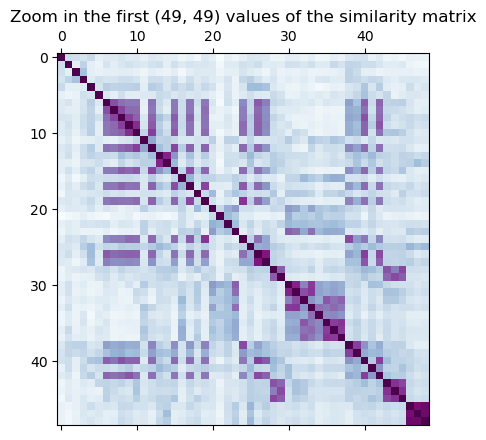

In [116]:
plt.matshow(similarity_matrix[:49, :49], cmap='BuPu')
plt.title('Zoom in the first (49, 49) values of the similarity matrix')

### Top, bottom and outlier analysis
Find the articles with the highest and lowest mean name similarity

In [59]:
mean_similarity, similarity_std = sm.similarity_mean_std(similarity_matrix)

df_articles = pd.DataFrame()
df_articles['article_name'] = df_article_names
df_articles['mean_similarity'] = mean_similarity
df_articles['similarity_std'] = similarity_std
df_articles['z_score'] = (mean_similarity - np.mean(mean_similarity)) / np.std(mean_similarity)

sorted_df = df_articles.sort_values(by='mean_similarity', ascending=False)


# Top and bottom n articles
n = 9
print("\nTop 10 Articles:")
print(sorted_df.head(n))
print("\nBottom 10 Articles:")
print(sorted_df.tail(n))

Removed the diagonal to get a matrix of shape (4604, 4603)
Mean similarity and std per article have shape (4604,)

Top 10 Articles:
      article_name  mean_similarity  similarity_std   z_score
2025         Human         0.463439        0.072948  2.905395
103   Acceleration         0.458636        0.070309  2.777373
4437       Weather         0.457683        0.075819  2.751968
3720          Ship         0.451414        0.072591  2.584877
460          Bantu         0.450903        0.072317  2.571258
2785        Mining         0.449293        0.073298  2.528340
192      Algorithm         0.447776        0.074392  2.487903
1511          Fire         0.447761        0.073513  2.487519
1631          Game         0.447358        0.082029  2.476764

Bottom 10 Articles:
                                           article_name  mean_similarity  \
2496                         List of Oceanian countries         0.219506   
2517                             List of vegetable oils         0.219250   

In [ ]:
upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1) # Flatten the upper triangle of the matrix without the diagonal for sorting

# Get the sorted indices for most similar pairs (descending order)
sorted_similar_indices = np.argsort(-similarity_matrix[upper_triangle_indices])
top_similar_pairs = list(zip(upper_triangle_indices[0][sorted_similar_indices], 
                             upper_triangle_indices[1][sorted_similar_indices]))

print("Top 5 most similar pairs:")
for i, (idx1, idx2) in enumerate(top_similar_pairs[:5]):
    print(f"Pair {i+1}: Articles '{df_article_names[idx1]}' and '{df_article_names[idx2]}' with similarity {similarity_matrix[idx1, idx2]:.4f}")

sorted_dissimilar_indices = np.argsort(similarity_matrix[upper_triangle_indices])
top_dissimilar_pairs = list(zip(upper_triangle_indices[0][sorted_dissimilar_indices], 
                                upper_triangle_indices[1][sorted_dissimilar_indices]))

# Print the top 5 most dissimilar pairs
print("\nTop 5 most dissimilar pairs:")
for i, (idx1, idx2) in enumerate(top_dissimilar_pairs[:5]):
    print(f"Pair {i+1}: Articles '{df_article_names[idx1]}' and '{df_article_names[idx2]}' with similarity {similarity_matrix[idx1, idx2]:.4f}")


Top 5 most similar pairs:
Pair 1: Articles 'Polish–Muscovite War (1605–1618)' and 'Polish-Muscovite War (1605–1618)' with similarity 0.9983
Pair 2: Articles 'Democratic Republic of the Congo' and 'Republic of the Congo' with similarity 0.9681
Pair 3: Articles 'George H. W. Bush' and 'George W. Bush' with similarity 0.9658
Pair 4: Articles 'Canadian Senate' and 'Senate of Canada' with similarity 0.9625
Pair 5: Articles 'Gliese 876' and 'Gliese 876 d' with similarity 0.9453

Top 5 most dissimilar pairs:
Pair 1: Articles 'Augustan literature' and 'Keira Knightley' with similarity 0.0301
Pair 2: Articles 'List of Test cricket triple centuries' and 'Venezuela' with similarity 0.0363
Pair 3: Articles 'List of Test cricket triple centuries' and 'São Paulo' with similarity 0.0373
Pair 4: Articles 'Brasília' and 'List of Test cricket triple centuries' with similarity 0.0399
Pair 5: Articles 'Cuba' and 'List of Test cricket triple centuries' with similarity 0.0433


### Cluster Analysis (Hierarchical Clustering)
Find clusters of words that are more similar to each other than to words in other clusters. At the bottom of the tree, most similar pairs are formed, then pairs of pairs are compared and so on. Check out <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html> this link </a> for more detail and <a href=https://stackoverflow.com/questions/66969893/scipy-and-the-hierarchical-clustering-input> this </a> or <a href=https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial> this link </a> to get a somewhat intuitive idea how how 2D clustering works. The clustering allows to reorder the similarity matrix in a way that regroups articles with high similarity. More analysis needs to be done to understand what the clusters essentially are and represent.

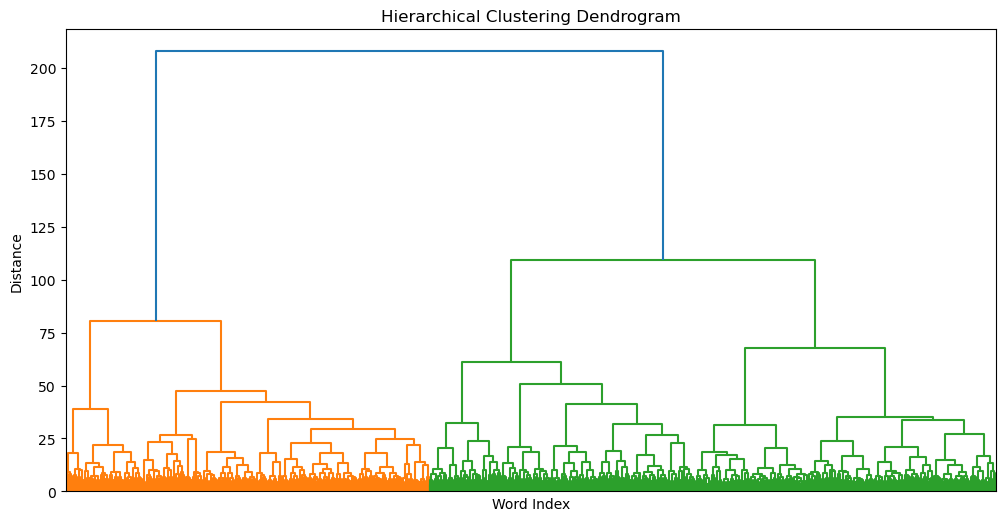

In [108]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

# Perform hierarchical clustering
linkage_matrix = linkage(similarity_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Word Index')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,    
    labelbottom=False)
plt.ylabel('Distance')
plt.show()


The first two columns show the pairs that are linked. Each new pair gets the lowest available index.
The second column shows the distance between the linked pair. 
The last column gives the cumulative number of items that were paired up to point.
[[ 5.          6.          0.          2.        ]
 [ 2.          7.          0.          2.        ]
 [ 0.          4.          1.          2.        ]
 [ 1.          8.          1.15470054  3.        ]
 [ 9.         10.          2.12132034  4.        ]
 [ 3.         12.          4.11096096  5.        ]
 [11.         13.         14.07183949  8.        ]]


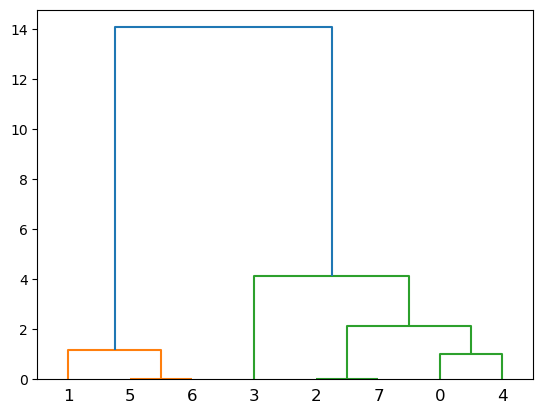

In [ ]:
# simple example to understand linkage
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
Z = linkage(X, 'ward')
print('The first two columns show the pairs that are linked. Each new pair gets the lowest available index.')
print('The second column shows the distance between the linked pair. ')
print('The last column gives the cumulative number of items that were paired up to point.')
print(Z)
dn = dendrogram(Z)

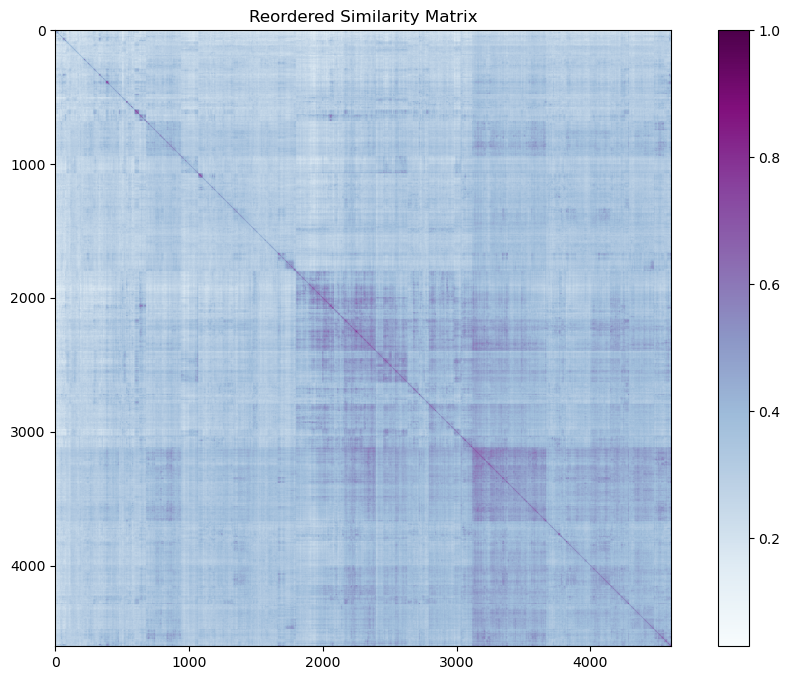

In [113]:
ordered_indices = leaves_list(linkage_matrix)
reordered_matrix = similarity_matrix[ordered_indices, :][:, ordered_indices]

plt.figure(figsize=(12, 8))
plt.imshow(reordered_matrix, cmap='BuPu')
plt.title('Reordered Similarity Matrix')
plt.colorbar()
plt.show()

In [ ]:
print('The reordered article indices make intuitive sense, similar words are regrouped')
print(df_article_names[ordered_indices].head(10))
print(df_article_names[ordered_indices].tail(10))

2490                              List of Asian countries
2496                           List of Oceanian countries
2488                            List of African countries
2498                     List of South American countries
2493                           List of European countries
2504                                    List of countries
2495                     List of North American countries
2505            List of countries by system of government
2515                             List of sovereign states
2492    List of European Union member states by accession
Name: 0, dtype: object
1944           History
2802    Modern history
1397            Eocene
3140         Paleocene
3058         Oligocene
2791           Miocene
3272          Pliocene
1067        Cretaceous
317        Archaeology
3141      Paleontology
Name: 0, dtype: object


### Central Words (Eigenvector Centrality and PageRank)
Identify the most central or "important" words in terms of their overall similarity to other words.
In this case (fully connected graph) PageRank gives the same result as just taking the ordered means and eigenvector centrality gives homogeneous result.

In [ ]:
eigenvector_centrality_sorted, pagerank_sorted = sm.central_words(similarity_matrix)

In [33]:
n = 5
print("Eigenvector Centrality:")
print(f"Top {n} central articles:")
for idx, score in eigenvector_centrality_sorted[:n]:
    print(f"{df_article_names[idx]}: {score:.4f}")

print(f"\nBottom {n} central articles:")
for idx, score in eigenvector_centrality_sorted[-n:]:
    print(f"{df_article_names[idx]}: {score:.4f}")


print("\nPageRank:")
print(f"Top {n} central articles by PageRank:")
for idx, score in pagerank_sorted[:n]:
    print(f"{df_article_names[idx]}: {score:.4f}")

print(f"\nBottom {n} central articles by PageRank:")
for idx, score in pagerank_sorted[-n:]:
    print(f"{df_article_names[idx]}: {score:.4f}")

Eigenvector Centrality:
Top 5 central articles:
Áedán mac Gabráin: 0.0147
Åland: 0.0147
Édouard Manet: 0.0147
Éire: 0.0147
Óengus I of the Picts: 0.0147

Bottom 5 central articles:
Zionism: 0.0147
Zirconium: 0.0147
Zoroaster: 0.0147
Zuid-Gelders: 0.0147
Zulu: 0.0147

PageRank:
Top 5 central articles by PageRank:
Human: 0.0003
Acceleration: 0.0003
Weather: 0.0003
Ship: 0.0003
Bantu: 0.0003

Bottom 5 central articles by PageRank:
List of Archbishops of Canterbury: 0.0001
List of Asian countries: 0.0001
List of South American countries: 0.0001
List of Test cricket triple centuries: 0.0001
List of Canadian provinces and territories by area: 0.0001


### Spectral Analysis
Eigenvalues can give interesting information about the space spanned by the similarity vectors. The dominant eigenpair could have an interesting meaning but this needs to be researched further. There might also be a way to reorder the similarity matrix using the eigenpairs to get a more meaningful similarity matrix. Maybe the similarity matrix can also be transformed with the eigenvector basis to get something meaningful out of the data?

In [84]:
from numpy.linalg import eigh

eigenvalues, eigenvectors = eigh(similarity_matrix)
print(f'There are {len(np.unique(eigenvalues))} unique eigenvalues in the range [{min(eigenvalues):.4f}, {max(eigenvalues):.4f}]')

There are 4604 unique eigenvalues in the range [-0.0000, 1651.1792]


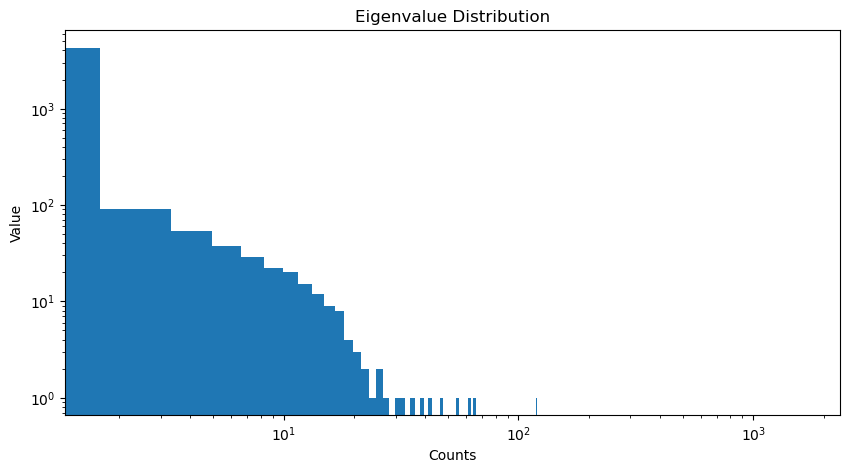

The 20 largest eigenvalues are 19.8, 20.1, 20.8, 21.6, 22.7, 24.3, 25.1, 25.8, 27.9, 30.0, 32.2, 35.7, 38.1, 41.5, 46.5, 55.0, 61.7, 64.7, 119.2, 1651.2


In [87]:
# Plot eigenvalue distribution
plt.figure(figsize=(10, 5))
plt.hist(eigenvalues, bins=1000)
plt.title('Eigenvalue Distribution')
plt.xlabel('Counts')
plt.ylabel('Value')
plt.yscale('log')
plt.xscale('log')
plt.show()

formatted_string = ', '.join(f'{value:.1f}' for value in eigenvalues[-20:])
print(f'The 20 largest eigenvalues are {formatted_string}')

Text(0.5, 1.0, 'Dominant eigenvector values')

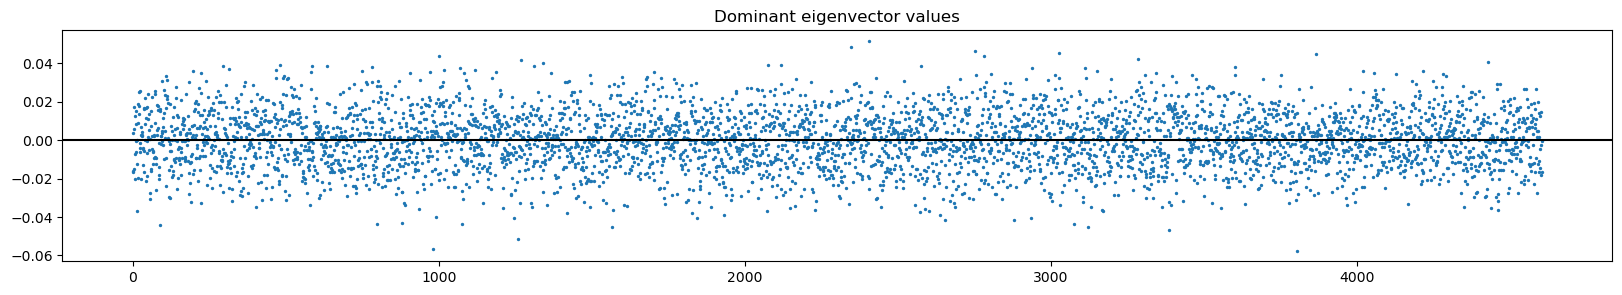

In [105]:
plt.figure(figsize=(20, 3))
max_eigenvector = eigenvectors[np.argmax(eigenvalues)]
plt.scatter(np.arange(len(max_eigenvector)), max_eigenvector, s=2)
plt.axhline(y=0, c='black')
plt.title('Dominant eigenvector values')